In [6]:
import sys
sys.modules[__name__].__dict__.clear()

In [ ]:

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from numpy.random import randn
from numpy.random import randint

#load train and test data

In [3]:
# load the trained generator
generator = tf.keras.models.load_model('D:/generator')



def generate_latent_points(latent_dim, n_samples, n_classes=2):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples) #check these labels!

    return z_input, labels


Tx = 3
nx = 20
latent_dim = 100
m = 1000   #number of samples you want to generate
z_input, Y_fake = generate_latent_points(latent_dim, m)
X_fake = generator.predict([z_input, Y_fake])
X_fake =X_fake[:,:,:,0]
X_fake = X_fake[:,0:Tx,:]

X_fake = X_fake.reshape((m,Tx,nx,1)).astype('float32')



In [9]:
from keras.layers import Conv1D, Dropout
from tensorflow.keras import initializers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from sklearn.metrics import  roc_auc_score

Tx=3

X_train_new, X_val, Y_train_new, Y_val = train_test_split(X_fake[:,0:Tx,:,0], Y_fake, test_size = 0.1, random_state=10)

x_test = np.concatenate((X_train[:,0:Tx,:,0],X_test[:14,0:Tx,:,0]),axis=0)
y_test = np.concatenate((Y_train,Y_test[:14]),axis=0)

model_CNN = Sequential()
model_CNN.add(Conv1D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(Tx,nx)))
model_CNN.add(Conv1D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(Flatten())
model_CNN.add(Dense(5,activation='sigmoid'))
model_CNN.add(Dense(1,activation='sigmoid'))
model_CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_CNN.fit(X_train_new, Y_train_new, epochs=500, batch_size=8, validation_data=(X_val,Y_val),verbose=0)
model_CNN.summary()

probs_val = model_CNN.predict_proba(X_val)
print(f'Validation ROC AUC  Score: {roc_auc_score(Y_val,probs_val)}')
probs = model_CNN.predict_proba(x_test)
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')
print(f'test accuracy: {model_CNN.evaluate(x_test, y_test)}')



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2, 16)             688       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             784       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,563
Trainable params: 1,563
Non-trainable params: 0
____________________________________________________

d:\farnaz2\wound project\virtual_env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
d:\farnaz2\wound project\virtual_env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [9]:
from sklearn.manifold import TSNE
X_t = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_f = X_fake.reshape((X_fake.shape[0],X_fake.shape[1]*X_fake.shape[2]))
X_tt = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
X_all = np.concatenate((X_t,X_tt,X_f),axis=0)
y_all = np.concatenate((Y_train,Y_test,Y_fake),axis=0)
X_embedded = TSNE(n_components=2).fit_transform(X_all)
ix_1 = y_all ==1
ix_0 = y_all == 0
ix_1_r = ix_1[:X_train.shape[0]]
ix_1_tt = ix_1[X_train.shape[0]:X_train.shape[0]+X_test.shape[0]]
ix_1_f = ix_1[X_train.shape[0]+X_test.shape[0]:]
ix_0_r = ix_0[:X_train.shape[0]]
ix_0_tt = ix_0[X_train.shape[0]:X_train.shape[0]+X_test.shape[0]]
ix_0_f = ix_0[X_train.shape[0]+X_test.shape[0]:]
X_emb_r = X_embedded[:X_train.shape[0],]
X_emb_tt = X_embedded[X_train.shape[0]:X_train.shape[0]+X_test.shape[0],]
X_emb_f = X_embedded[X_train.shape[0]+X_test.shape[0]:,]

X_emb_1_r = X_emb_r[ix_1_r]
X_emb_1_tt = X_emb_tt[ix_1_tt]
X_emb_1_f = X_emb_f[ix_1_f]
X_emb_0_r = X_emb_r[ix_0_r]
X_emb_0_tt = X_emb_tt[ix_0_tt]
X_emb_0_f = X_emb_f[ix_0_f]


n=70

plt.plot(X_emb_1_f[:,0],X_emb_1_f[:,1],'ro')
plt.plot(X_emb_1_r[:,0],X_emb_1_r[:,1],'bo')
plt.plot(X_emb_1_tt[:,0],X_emb_1_tt[:,1],'go')
plt.plot(X_emb_0_f[:,0],X_emb_0_f[:,1],'ro')
plt.plot(X_emb_0_r[:,0],X_emb_0_r[:,1],'bo')
plt.plot(X_emb_0_tt[:,0],X_emb_0_tt[:,1],'go')
plt.xlim(-n,n)
plt.ylim(-n,n)
plt.legend(['Synthetic Data','Real Train Data','Real Test Data'])
plt.title('EMR-TCWGAN')
plt.xlabel('x-tSNE')
plt.ylabel('y-tSNE')
plt.show()





plt.plot(X_emb_1_f[:,0],X_emb_1_f[:,1],'bo')
plt.plot(X_emb_0_r[:,0],X_emb_0_r[:,1],'ro')
plt.plot(X_emb_1_r[:,0],X_emb_1_r[:,1],'bo')
plt.plot(X_emb_0_f[:,0],X_emb_0_f[:,1],'ro')
plt.xlim(-n,n)
plt.ylim(-n,n)
plt.legend(['Healed', 'Not Healed'])
plt.title('EMR-TCWGAN')
plt.xlabel('x-tSNE')
plt.ylabel('y-tSNE')
plt.show()



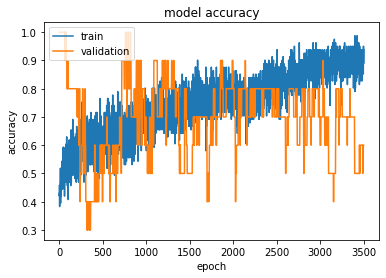

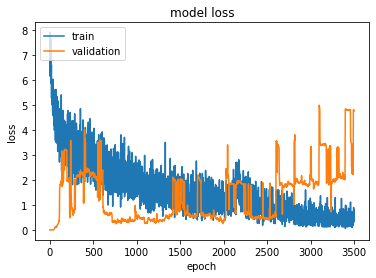

In [95]:
from sklearn import metrics

X_ph =np.concatenate((X_train,X_fake[:X_train.shape[0],:,:,:]),axis=0)
Y_ph = np.concatenate((np.ones((X_train.shape[0],)),np.zeros(X_train.shape[0],)),axis=0)

import tensorflow as tf
from keras.layers import  Dense, Dropout, Flatten, Conv2D, Input, ReLU, BatchNormalization,MaxPooling2D
from keras.models import Model
from keras import regularizers, initializers

def My_model_posthoc(Tx,nx):

    in_image= Input (shape=[Tx, nx, 1])
    fe = Conv2D(16,(3,3), strides=(2,2), padding='same',kernel_initializer= initializers.RandomNormal(seed=5), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(in_image)
    fe= ReLU()(fe)

    fe = Conv2D(32, (3,3), strides=(2,2),padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = ReLU()(fe)
    fe = Dropout(0.2)(fe)

    fe = Conv2D(16, (3,3), strides=(2,2),padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = ReLU()(fe)
    fe = Dropout(0.2)(fe)

    fe = Flatten()(fe)
    fe =  Dense(1)(fe)
    out1 = ReLU()(fe)

    model = Model(in_image, out1)
    #model.summary()
    return model

loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
met= tf.keras.metrics.BinaryAccuracy()

def score_test(x,y,model_CNN):
    pred_test = model_CNN.predict(x)
    score = model_CNN.evaluate(x, y)
    fpr, tpr, thresholds = metrics.roc_curve(y, pred_test.reshape((pred_test.shape[0],)))
    auc = metrics.auc(fpr, tpr)
    return  pred_test, auc, fpr, tpr, score


model_posthoc = My_model_posthoc(Tx,nx)
model_posthoc.compile(loss=loss, optimizer=opt, metrics=met)
history=model_posthoc.fit(X_ph,Y_ph, batch_size=8, epochs= 2500, verbose=0, validation_split=0.1 , shuffle=True )

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


X_ph_t =X_fake[X_train.shape[0]:,:,:,:]
Y_ph_t = np.zeros((X_ph_t.shape[0],))

pred_test, auc, fpr, tpr, score = score_test(X_ph_t,Y_ph_t,model_posthoc)

print("Test Accuracy:" , 100*score[1])
plt.plot(pred_test,'*--')
plt.plot(Y_ph_t,'o--')
plt.xlabel('Test patients')
plt.ylabel('Output')
plt.legend(['Predicted' , 'True'])
plt.show()


In [ ]:
Tx = 3
X_train_cont_1 = np.concatenate((X_train[:,0,0:Tx,0],X_test[:,0,0:Tx,0]),axis=0)
X_train_cont_2 = np.concatenate((X_train[:,1,0:Tx,0],X_test[:,1,0:Tx,0]),axis=0)
X_train_cont_3 = np.concatenate((X_train[:,2,0:Tx,0],X_test[:,2,0:Tx,0]),axis=0)

X_fake_cont_1 = X_fake[:,0,0:Tx,0]
X_fake_cont_2 = X_fake[:,1,0:Tx,0]
X_fake_cont_3 = X_fake[:,2,0:Tx,0]

In [ ]:
X_train_cont_1 = np.concatenate((X_train[:,0,:,0],X_test[:,0,:,0]),axis=0)
X_train_cont_2 = np.concatenate((X_train[:,1,:,0],X_test[:,1,:,0]),axis=0)
X_train_cont_3 = np.concatenate((X_train[:,2,:,0],X_test[:,2,:,0]),axis=0)

X_fake_cont_1 = X_fake[:60,0,:,0]
X_fake_cont_2 = X_fake[:60,1,:,0]
X_fake_cont_3 = X_fake[:60,2,:,0]

In [ ]:
from scipy.spatial.distance import jensenshannon
js_1c =[]
for f in range(X_fake_cont_1.shape[1]):

    p = np.histogram(X_train_cont_1[:,f],bins=10,range=[-3,3])
    qf = np.histogram(X_fake_cont_1[:60,f],bins=10,range=[-3,3])
    js_1c.append(jensenshannon(p[0]/60, q[0]/60, base=2))

print(q[0])
print(q[1])

print(p[0])
print(p[1])
x = [-3,  -2.4, -1.8, -1.2, -0.6,   0.6  ,1.2 , 1.8  ,2.4 , 3 ]
plt.plot(x,p[0]/60)
plt.plot(x,q[0]/60)
plt.plot(x,qf[0]/60)
plt.show()

In [ ]:
plt.hist(X_train_cont_1[:,f],bins=10,range=[-3,3])
plt.show()
plt.hist(X_fake_cont_1[:,f],bins=10,range=[-3,3])
plt.show()

In [ ]:
print(np.asarray(js_1f).mean())
print(np.asarray(js_1c).mean())

print(np.asarray(js_2f).mean())
print(np.asarray(js_2c).mean())

print(np.asarray(js_3f).mean())
print(np.asarray(js_3c).mean())


print(js_1f[0:3])
print(js_2f[0:3])
print(js_3f[0:3])

print(js_1c[0:3])
print(js_2c[0:3])
print(js_3c[0:3])

In [ ]:
f=2
p = np.histogram(X_train_cont_3[:,f],bins=5,range=[-1,1])
q = np.histogram(X_fake_cont_3[:60,f],bins=5,range=[-1,1])
print(p[0]/60)
print(q)


# calculate JS(P || Q)
js_pq = jensenshannon(p[0]/60, q[0]/60, base=2)
print('JS(P || Q) Distance: %.3f' % js_pq)
# calculate JS(Q || P)
js_qp = jensenshannon(q[0]/60, p[0]/60, base=2)
print('JS(Q || P) Distance: %.3f' % js_qp)


In [ ]:
f=0
import seaborn as sns
ax = sns.distplot(X_train_cont_1[:,f],hist=False, kde=True)
ax = sns.distplot(X_train_cont_2[:,f],hist=False, kde=True)
ax = sns.distplot(X_train_cont_3[:,f],hist=False, kde=True)
ax.set(xlabel='Wound Length Distribution', ylabel='Frequency')
ax.legend(['First visit','Second visit', 'Third visit'])
fig = ax.get_figure()
fig.savefig('D:\Farnaz2\Wound Project\Model_complete_Data_02012021\WGAN-FS14-categorical_cnn/wound length real')

In [ ]:
ax2 = sns.distplot(X_fake_cont_1[:,f],hist=False, kde=True)
ax2 = sns.distplot(X_fake_cont_2[:,f],hist=False, kde=True)
ax2 = sns.distplot(X_fake_cont_3[:,f],hist=False, kde=True)
ax2.set(xlabel='Wound Length Distribution', ylabel='Frequency')
ax2.legend(['First visit','Second visit', 'Third visit'])
fig = ax2.get_figure()
fig.savefig('D:\Farnaz2\Wound Project\Model_complete_Data_02012021\WGAN-FS14-categorical_cnn/wound length fake')